# Implementation of FedAvg with PyTorch on IID Data

## Section 0. Libraries and Packages

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import tree
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import math
from matplotlib import pyplot
from pathlib import Path
import requests
import pickle
import gzip
import torch
import math
pd.options.display.float_format = "{:,.4f}".format

## Section 1. Data Loading

Datase size : ((50000, 784), (50000,)) ((10000, 784), (10000,)) ((10000, 784), (10000,))


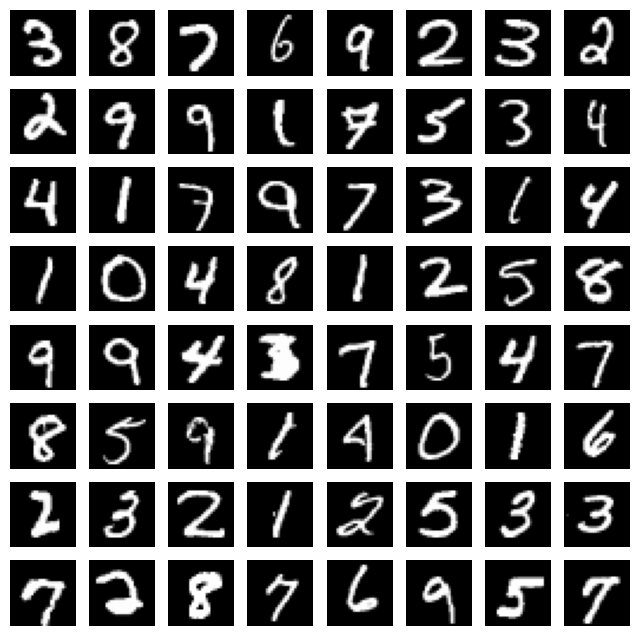

In [12]:
DATA_PATH = Path("C:/Users/aliasgarov/Documents/Workspace/University/Guided Research I/Repo/guidedresearchproject-aliasgerovs/data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)
FILENAME = "mnist.pkl.gz"

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

print('Datase size :', (x_train.shape, y_train.shape) ,(x_valid.shape, y_valid.shape), (x_test.shape, y_test.shape))

fig, axes = pyplot.subplots(8,8,figsize=(8,8))
for i in range(8):
    for j in range(8):
        num_index = np.random.randint(len(x_train))
        axes[i,j].imshow(x_train[num_index].reshape((28,28)), cmap="gray")
        axes[i,j].axis("off")
pyplot.show() 

### Here we can check how many of each tag are

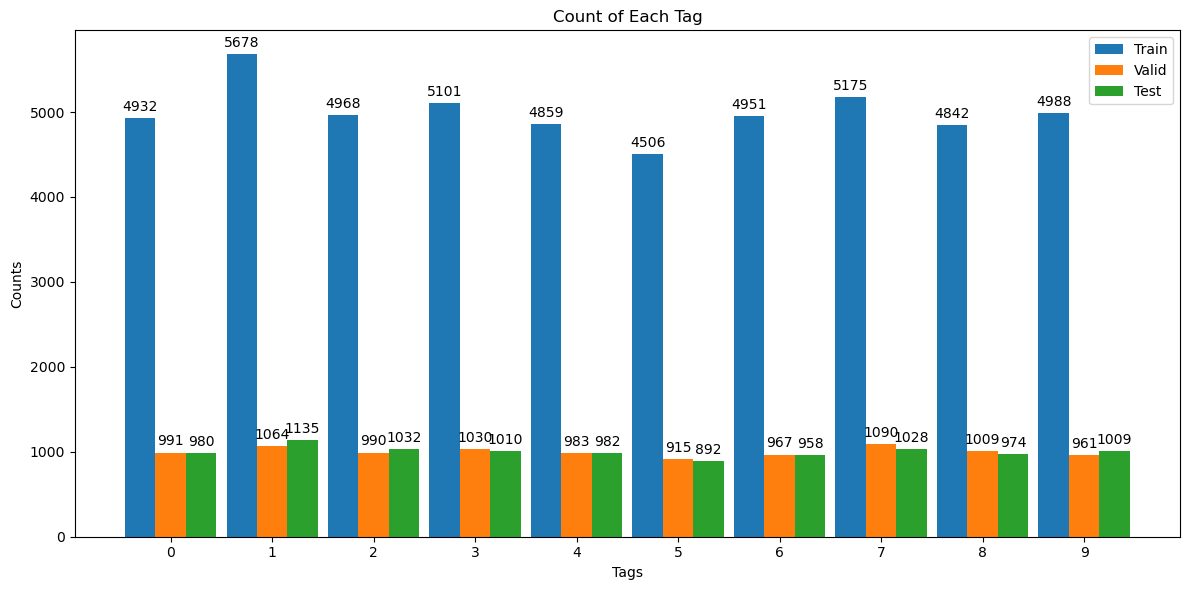

In [13]:
y_train_counts = [sum(y_train == i) for i in range(10)]
y_valid_counts = [sum(y_valid == i) for i in range(10)]
y_test_counts = [sum(y_test == i) for i in range(10)]

y_train_total = sum(y_train_counts)
y_valid_total = sum(y_valid_counts)
y_test_total = sum(y_test_counts)
total = y_train_total + y_valid_total + y_test_total

tags = range(10)
train_counts = [sum(y_train == i) for i in tags]
valid_counts = [sum(y_valid == i) for i in tags]
test_counts = [sum(y_test == i) for i in tags]

x = range(len(tags))
width = 0.3

fig, ax = plt.subplots(figsize=(12, 6)) 
rects1 = ax.bar(x, train_counts, width, label='Train')
rects2 = ax.bar([val + width for val in x], valid_counts, width, label='Valid')
rects3 = ax.bar([val + width * 2 for val in x], test_counts, width, label='Test')

ax.set_xlabel('Tags')
ax.set_ylabel('Counts')
ax.set_title('Count of Each Tag')
ax.set_xticks([val + width for val in x])
ax.set_xticklabels(tags)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.tight_layout()
plt.show()

## Classification Model

In [16]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net2nn()
print(model)

Net2nn(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)


In [19]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        

    return train_loss / len(train_loader), correct/len(train_loader.dataset)

In [20]:
def validation(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            
            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)

### Let's examine what would the performance of the centralized model be if the data were not distributed to nodes at all? </span>   


In [21]:
x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))
number_of_samples=100
learning_rate = 0.01
numEpoch = 10
batch_size = 32
momentum = 0.9

train_amount=4500
valid_amount=900
test_amount=900
print_amount=3

C:\Users\aliasgarov\AppData\Local\Temp\ipykernel_14600\1350096759.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))


In [22]:
centralized_model = Net2nn()
centralized_optimizer = torch.optim.SGD(centralized_model.parameters(), lr=0.01, momentum=0.9)
centralized_criterion = nn.CrossEntropyLoss()

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

print("------ Centralized Model ------")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy = train(centralized_model, train_dl, centralized_criterion, centralized_optimizer)
    central_test_loss, central_test_accuracy = validation(centralized_model, test_dl, centralized_criterion)
    
    print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.4f}".format(central_train_accuracy) + " | test accuracy: {:7.4f}".format(central_test_accuracy))

print("------ Training finished ------")

------ Centralized Model ------
epoch:   1 | train accuracy:  0.8779 | test accuracy:  0.9455
epoch:   2 | train accuracy:  0.9563 | test accuracy:  0.9641
epoch:   3 | train accuracy:  0.9706 | test accuracy:  0.9657
epoch:   4 | train accuracy:  0.9774 | test accuracy:  0.9724
epoch:   5 | train accuracy:  0.9829 | test accuracy:  0.9749
epoch:   6 | train accuracy:  0.9860 | test accuracy:  0.9763
epoch:   7 | train accuracy:  0.9890 | test accuracy:  0.9772
epoch:   8 | train accuracy:  0.9925 | test accuracy:  0.9776
epoch:   9 | train accuracy:  0.9936 | test accuracy:  0.9765
epoch:  10 | train accuracy:  0.9948 | test accuracy:  0.9805
------ Training finished ------


## Data Distrubuted to Nodes

In [23]:
def create_iid_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    x_data_dict= dict()
    y_data_dict= dict()
    
    for i in range(len(sample_dict)): 
        xname= x_name+str(i)
        yname= y_name+str(i)
        sample_name="sample"+str(i)
        
        indices=np.sort(np.array(sample_dict[sample_name]["i"]))
        
        x_info= x_data[indices,:]
        x_data_dict.update({xname : x_info})
        
        y_info= y_data[indices]
        y_data_dict.update({yname : y_info})
        
    return x_data_dict, y_data_dict


def split_and_shuffle_labels(y_data, seed, amount):
    y_data=pd.DataFrame(y_data,columns=["labels"])
    y_data["i"]=np.arange(len(y_data))
    label_dict = dict()
    for i in range(10):
        var_name="label" + str(i)
        label_info=y_data[y_data["labels"]==i]
        np.random.seed(seed)
        label_info=np.random.permutation(label_info)
        label_info=label_info[0:amount]
        label_info=pd.DataFrame(label_info, columns=["labels","i"])
        label_dict.update({var_name: label_info })
    return label_dict


def get_iid_subsamples_indices(label_dict, number_of_samples, amount):
    sample_dict= dict()
    batch_size=int(math.floor(amount/number_of_samples))
    for i in range(number_of_samples):
        sample_name="sample"+str(i)
        dumb=pd.DataFrame()
        for j in range(10):
            label_name=str("label")+str(j)
            a=label_dict[label_name][i*batch_size:(i+1)*batch_size]
            dumb=pd.concat([dumb,a], axis=0)
        dumb.reset_index(drop=True, inplace=True)    
        sample_dict.update({sample_name: dumb}) 
    return sample_dict

In [ ]:
def create_model_optimizer_criterion_dict(number_of_samples):
    model_dict = dict()
    optimizer_dict= dict()
    criterion_dict = dict()
    
    for i in range(number_of_samples):
        model_name="model"+str(i)
        model_info=Net2nn()
        model_dict.update({model_name : model_info })
        
        optimizer_name="optimizer"+str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum)
        optimizer_dict.update({optimizer_name : optimizer_info })
        
        criterion_name = "criterion"+str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name : criterion_info})
        
    return model_dict, optimizer_dict, criterion_dict 